# us open

the us open is this weekend, and I wanted to play around with a few machine learning models to see if I could predict:

* who wil make the cut
* who will finish where

these two questions can be answered with machine learning classificaiton and regression problems. to predict who will make the cut, we will have a training data set that contains player name, season several strokes gained variables and whether they made they cut or not. this training data set contains data from only US opens in 2019, 2021 and 2022. 

the testing data set will then contain player name, season and the same strokes gained variables from tournaments thus far (through RBC heritage canadian open) in 2023. I believe to score the model we need to have data on who actually makes the cut in the 2023 US open... so I am not sure if we can fully answer this question yet.

to predict who will finish where, we can run a regression model that uses the strokes gained variables and year to predict finish from those previous three US opens. we can train a model on the same data, except the "target" variable is no longer binary (0/1). the testing data set will be the same as above, and we should be able to use the `predict()` function to predict finsh in this year's US open, based on average strokes gained this season

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
# we want plots to appear in line in the notebook

# models from sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# model evals

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

## read in the data

I played around with this same data in R, so I have created all the training and testing files already

### classification problem: who makes the cut?

In [29]:
train_class = pd.read_csv("usopen_classification_train.csv")

In [30]:
train_class.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,finish_class
0,5548,2022,1.30,0.80,0.54,0.21,1
1,3832,2022,-1.42,0.73,0.87,-0.81,0
2,5502,2022,1.43,0.60,-0.48,-0.45,1
3,10372,2022,0.66,0.65,0.14,0.14,1
4,388,2022,0.54,0.79,1.20,-0.43,1


In [31]:
train_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player id     478 non-null    int64  
 1   season        478 non-null    int64  
 2   sg_putt       478 non-null    float64
 3   sg_arg        478 non-null    float64
 4   sg_app        478 non-null    float64
 5   sg_ott        478 non-null    float64
 6   finish_class  478 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 26.3 KB


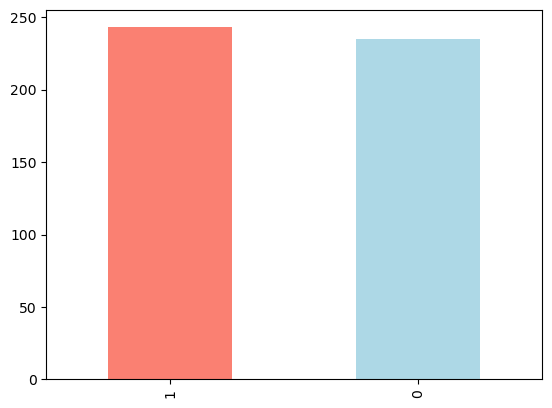

In [12]:
train_class.finish_class.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

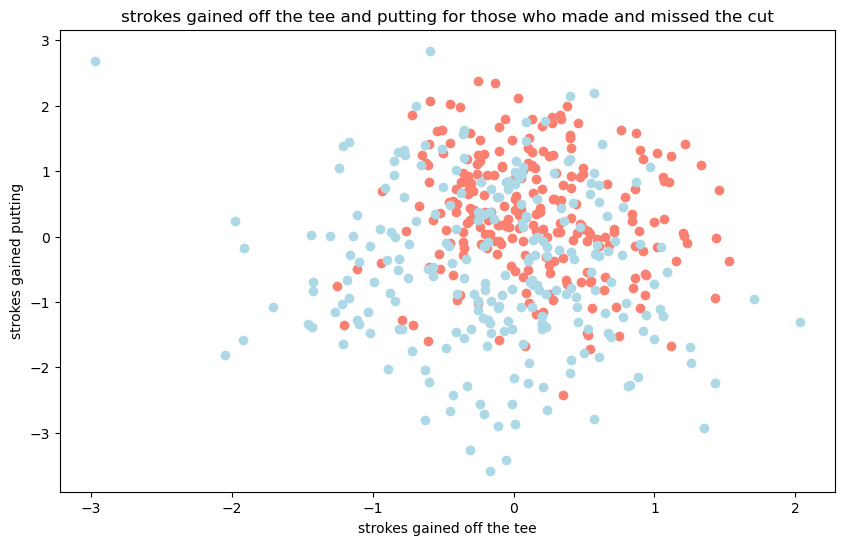

In [21]:
plt.figure(figsize=(10,6))

# scatter

plt.scatter(train_class.sg_ott[train_class.finish_class==1],
           train_class.sg_putt[train_class.finish_class==1],
           color="salmon")

# scatter with negative examples

plt.scatter(train_class.sg_ott[train_class.finish_class==0],
           train_class.sg_putt[train_class.finish_class==0],
           c="lightblue")

plt.title("strokes gained off the tee and putting for those who made and missed the cut")

plt.xlabel("strokes gained off the tee")
plt.ylabel("strokes gained putting")
plt.xticks(rotation=0);

overall, our data looks fairly similar for those who made the cut and missed the cut. that might mean something like the IS open is a competitive field where players are all playing at a high clip... and might be hard to build a model with a high prediction accuracy!

#### begin building a model that predicts who will make or miss the cut just based on the training data

we are going to only use the training data set (and split that into training and testing) for now to score and create a model that predicts with high accuracy

In [32]:
# split data into x and y

x= train_class.drop("finish_class", axis=1)

y= train_class.finish_class

In [33]:
np.random.seed(22)

# split into training and testing data (again, here just using the old training data)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [48]:
### logistic regression

np.random.seed(42)

logreg= LogisticRegression()

logreg.fit(x_train,y_train)
logreg.score(x_test,y_test) ### not very good


0.5833333333333334

In [49]:
## random forest

np.random.seed(42)

RF= RandomForestClassifier()

RF.fit(x_train,y_train)
RF.score(x_test,y_test) ### better

0.8229166666666666

#### tune hyper parameters with `gridsearchCV()`

In [45]:
# diff hyper params for logistic regression

log_reg_grid= {"C": np.logspace(-4,4,30),
              "solver": ["liblinear"]} 

# set up grid hyper param search

gs_reg= GridSearchCV(LogisticRegression(),
                    param_grid=log_reg_grid,
                    cv=5,
                    verbose=True)

# fit

gs_reg.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [46]:
# check best params

gs_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [47]:
gs_reg.score(x_train,y_train) ### not performing well

0.5130890052356021

In [54]:
# diff hyper params for random forest

rf_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

gs_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# fit

gs_rf.fit(x_train,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require In

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [55]:
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

In [56]:
# create model based on those best parameters identified

clf= RandomForestClassifier(bootstrap=True,
                           max_depth=100,
                           max_features=2,
                            min_samples_leaf=5,
                            min_samples_split=10,
                            n_estimators=100)

In [57]:
### cross validated accuracy

cv_acc = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="accuracy")

cv_acc.mean() ## accuracy over 80% for cross validated data

0.8139473684210525

In [58]:
### cross validated precision

cv_prec = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="precision")

cv_prec.mean() ## precision over 80%

0.8368020676646019

In [59]:
### cross validated recall

cv_recall = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="recall")

cv_recall.mean() # recall close to 80%

0.7982993197278911

In [60]:
### cross validated F1 score

cv_f1 = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="f1")

cv_f1.mean() ## F1 score over 80%

0.8132108920713426

In [61]:
# actually run that model and predict (still only on training data)

clf.fit(x_train,y_train)

clf.score(x_train,y_train) # nice job!! 

0.9293193717277487

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sampl

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sam

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sampl

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samp

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samp

our model, on only training data so far, is predicting who makes or misses the cut with almost 93% accuracy

In [64]:
y_preds= clf.predict(x_test) # best fitting model

In [65]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


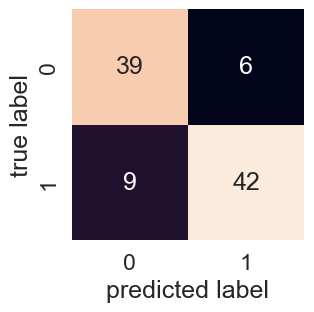

In [67]:
import seaborn as sns 

sns.set(font_scale=1.5)

def plot_conf_mat(y_test,y_preds):
    """
    Plots a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax=plt.subplots(figsize=(3,3))
    ax= sns.heatmap(confusion_matrix(y_test,y_preds),
                   annot=True,
                   cbar=False)
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    
plot_conf_mat(y_test,y_preds)

overall, we only had 9 + 6 incorrect predictions

#### now, let's make predictions based on the 2023 strokes gained data

In [71]:
test = pd.read_csv("usopen_test.csv")

In [72]:
test.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott
0,16,2023,0.351,0.534,0.025,-0.423
1,10577,2023,0.559,0.228,-0.795,-0.170
2,5548,2023,0.356,0.103,0.350,0.048
3,6015,2023,0.406,0.094,-0.539,-0.285
4,10372,2023,0.355,0.106,0.099,0.024


In [73]:
us_open_preds= clf.predict(test)

In [75]:
us_open_preds

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1])

In [77]:
test["preds"]= us_open_preds

In [78]:
test.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,preds
0,16,2023,0.351,0.534,0.025,-0.423,1
1,10577,2023,0.559,0.228,-0.795,-0.170,0
2,5548,2023,0.356,0.103,0.350,0.048,1
3,6015,2023,0.406,0.094,-0.539,-0.285,1
4,10372,2023,0.355,0.106,0.099,0.024,1


In [93]:
# match with player names to see who we will predict will make the cut

ids= pd.read_csv("us_open_ids.csv")

In [94]:
ids.head()

,player,player id
0,Adam Hadwin,5548
1,Alexander Noren,3832
2,Andrew Putnam,5502
3,Adam Schenk,10372
4,Adam Scott,388


In [95]:
df = pd.merge(test, ids, on="player id")
df

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,preds,player
0,16,2023,0.351,0.534,0.025,-0.423,1,Aaron Baddeley
1,10577,2023,0.559,0.228,-0.795,-0.170,0,Aaron Wise
2,5548,2023,0.356,0.103,0.350,0.048,1,Adam Hadwin
3,6015,2023,0.406,0.094,-0.539,-0.285,1,Adam Long
4,10372,2023,0.355,0.106,0.099,0.024,1,Adam Schenk
...,...,...,...,...,...,...,...,...
116,1614,2023,-0.162,-0.207,0.193,-0.405,0,Webb Simpson
117,11119,2023,0.292,0.147,0.548,0.231,1,Wyndham Clark
118,10140,2023,0.577,0.148,0.888,0.338,1,Xander Schauffele
119,9040,2023,-0.092,0.319,-0.102,-0.394,1,Zac Blair


In [96]:
df.shape

(121, 8)

In [97]:
test.shape

(121, 7)

In [103]:
cut_preds = df.filter(['player', 'preds'], axis=1)

In [109]:
cut_preds

,player,preds
0,Aaron Baddeley,1
1,Aaron Wise,0
2,Adam Hadwin,1
3,Adam Long,1
4,Adam Schenk,1
...,...,...
116,Webb Simpson,0
117,Wyndham Clark,1
118,Xander Schauffele,1
119,Zac Blair,1


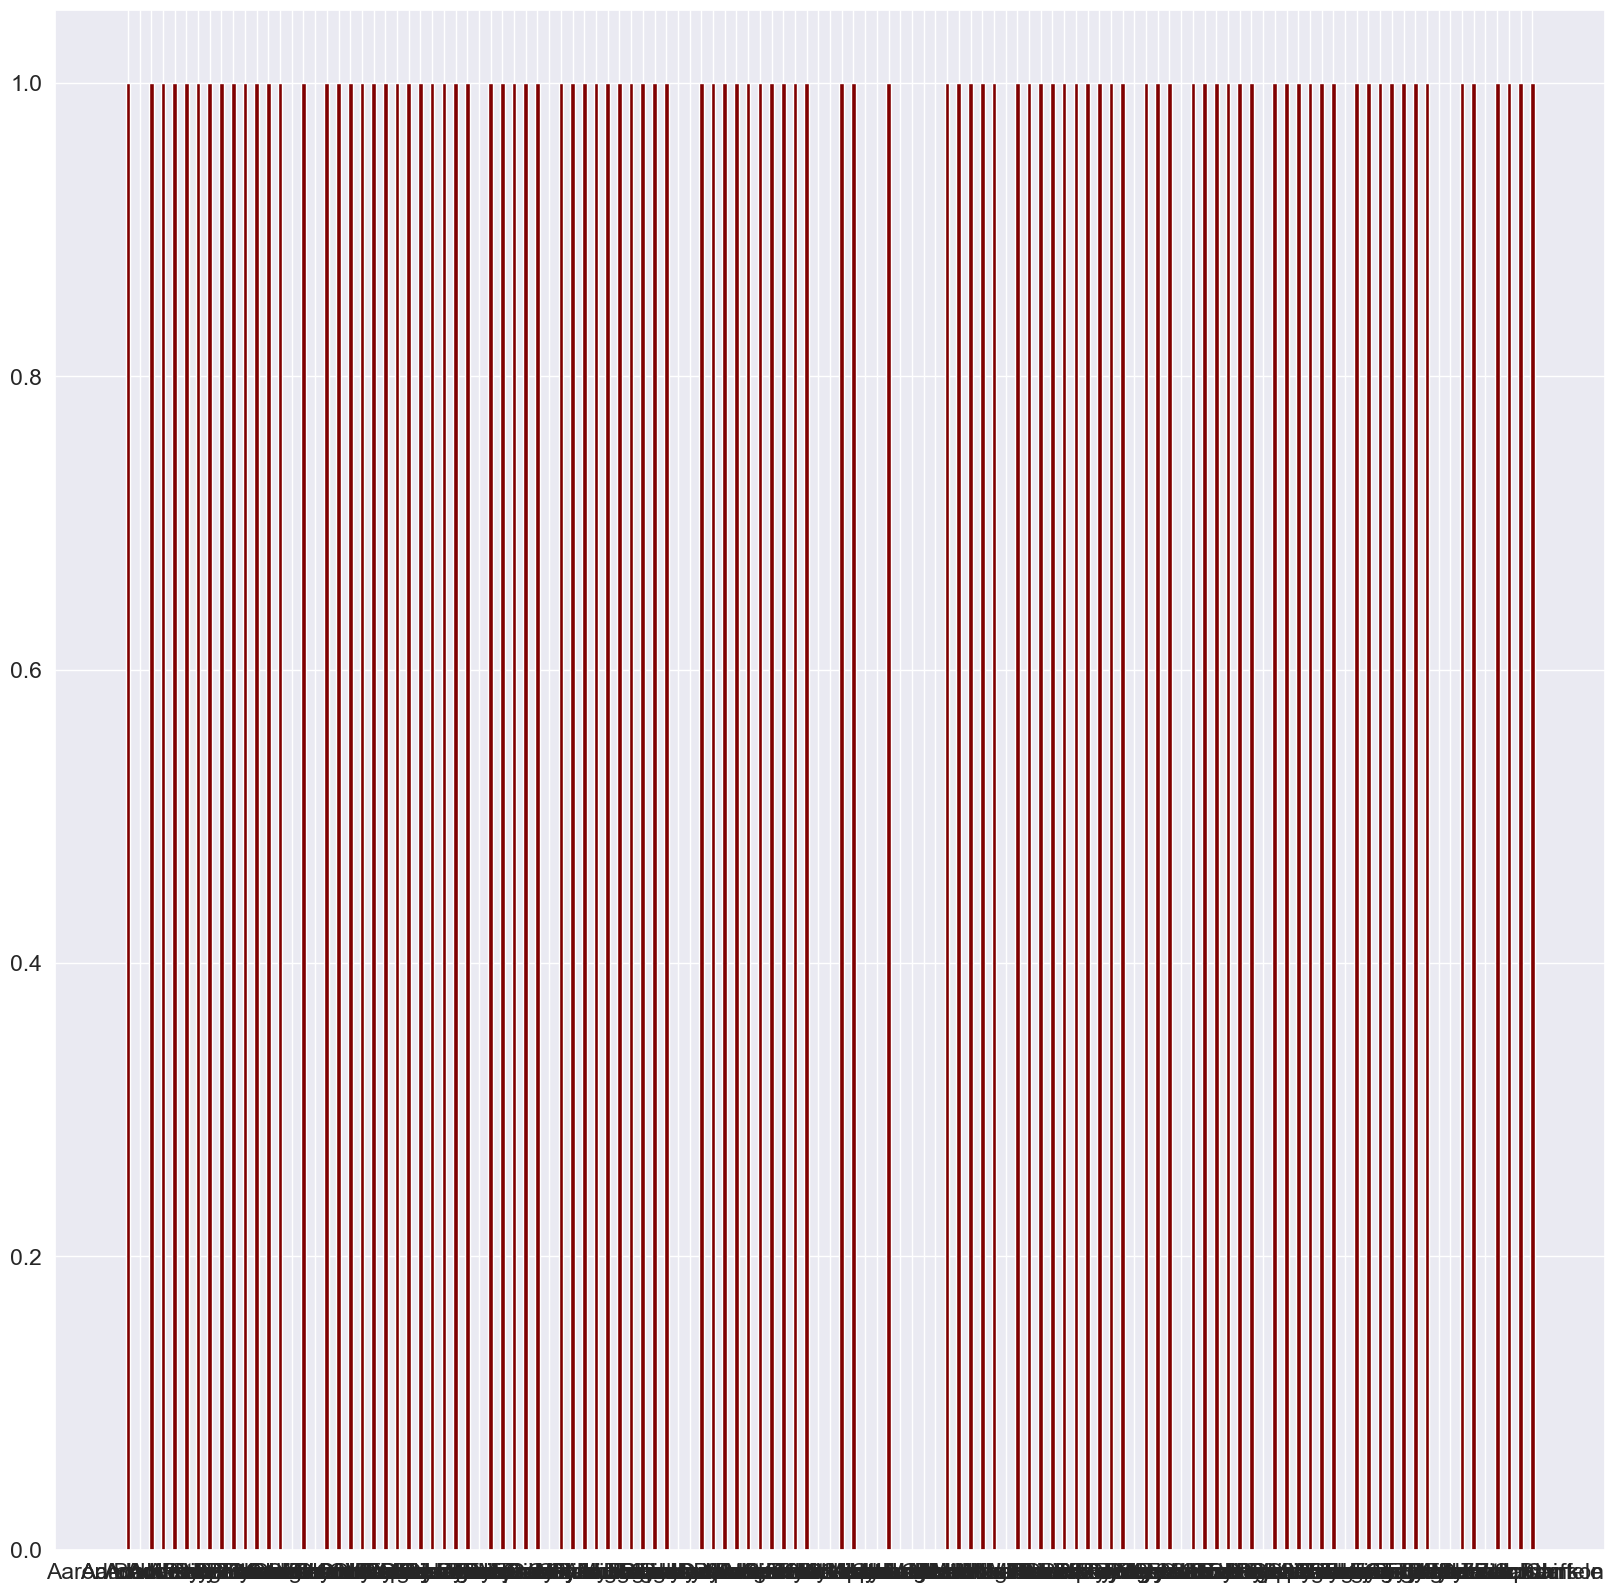

In [123]:
plt.figure(figsize=(20,20))

plt.bar(cut_preds.player, cut_preds.preds, color ='maroon',
        width = 0.4);

## linear regression: who finishes where?

In [128]:
train= pd.read_csv("usopen_regression_train.csv")

In [129]:
train.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,finish2
0,5548,2022,1.30,0.80,0.54,0.21,7
1,3832,2022,-1.42,0.73,0.87,-0.81,78
2,5502,2022,1.43,0.60,-0.48,-0.45,31
3,10372,2022,0.66,0.65,0.14,0.14,24
4,388,2022,0.54,0.79,1.20,-0.43,14


In [130]:
# call model

from sklearn.ensemble import RandomForestRegressor

model= RandomForestRegressor(n_jobs=-1,
                            random_state=42)


# fit

model.fit(train.drop("finish2", axis=1), train.finish2)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [133]:
model.score(train.drop("finish2", axis=1), train.finish2)

0.9706055744153341

our model predicts finish based on only on the training data with 97% accuracy! that's pretty crazy

In [180]:
# split training data into x and y

x_train, y_train= train.drop("finish2", axis=1), train.finish2

In [181]:
x_train.shape, y_train.shape

((478, 6), (478,))

In [182]:
from sklearn.model_selection import RandomizedSearchCV

# different `RandomForestRegressor` hyperparameters

rf_grid = {"n_estimators": np.arange(10,100,10),
          "max_depth": [None, 3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf": np.arange(1,20,1),
          "max_features": [0.5,1,"sqrt", "auto"],
          "max_samples": [278]}

# call `RandomizedSearchCV` model

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                            param_distributions= rf_grid,
                            n_iter=2,
                            cv=5,
                            verbose=True)
# fit model

rs_model.fit(x_train,y_train)
                              
                    

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/claire/Desktop/ML_class/bulldozers/env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



/Users/claire/Desktop/ML_class/bulldozers/env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/claire/Desktop/ML_class/bulldozers/env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/claire/Desktop/ML_class/bulldozers/env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly s

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [278],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [167]:
rf_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,150,278]
}

gs_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = rf_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# fit

gs_rf.fit(x_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=10, min_samples_leaf=5, min_samples_split=8, n_estimators=278; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=10, min_samples_leaf=5, min_samples_split=12, n_estimators=278; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=10, min_samples_leaf=5, min_samples_split=12, n_estimators=278; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=3, min_samples_split=12, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=3, min_samples_split=12, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_d

[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=3, min_samples_split=12, n_estimators=150; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=4, min_samples_split=8, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=

[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=3, min_samples_split=12, n_estimators=278; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=4, min_samples_split=12, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=4, min_samples_split=12, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=5, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_leaf=5, min_samples_split=12, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=100, min_samples_lea

[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=4, min_samples_split=8, n_estimators=278; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=4, min_samples_split=8, n_estimators=278; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=5, min_samples_split=8, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=5, min_samples_split=8, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=5, min_samples_split=12, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, max_samples=10, min_samples_leaf=3, 

[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=5, min_samples_split=8, n_estimators=278; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, max_samples=200, min_samples_leaf=5, min_samples_split=8, n_estimators=278; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, max_samples=10, min_samples_leaf=3, min_samples_split=8, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, max_samples=10, min_samples_leaf=3, min_samples_split=8, n_estimators=278; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, max_samples=10, min_samples_leaf=3, min_samples_split=12, n_estimators=278; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, max_samples=10, min_samples_leaf=3, min

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 150, 278]},
             verbose=2)

In [183]:
gs_rf.score(x_train,y_train) ## 89%! pretty good R2

0.8799954142797908

In [184]:
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 278}

#### now we can create a model with the best parameters from `gridsearchCV()`

In [186]:
rf_model = RandomForestRegressor(n_estimators=278,
                                   min_samples_leaf=3,
                                   min_samples_split=8,
                                   max_features=3,
                                 max_depth=80,
                                   n_jobs=-1,
                                   random_state=42,
                                    bootstrap=True)

In [187]:
rf_model.fit(x_train,y_train)

RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=278, n_jobs=-1,
                      random_state=42)

In [188]:
rf_model.score(x_train,y_train) # 91%

0.9184388563232923

#### now we can make predictions on the testing data

In [189]:
test = pd.read_csv("usopen_test.csv")

In [190]:
test.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott
0,16,2023,0.351,0.534,0.025,-0.423
1,10577,2023,0.559,0.228,-0.795,-0.170
2,5548,2023,0.356,0.103,0.350,0.048
3,6015,2023,0.406,0.094,-0.539,-0.285
4,10372,2023,0.355,0.106,0.099,0.024


In [191]:
test_preds = rf_model.predict(test)

In [192]:
finish_preds = pd.DataFrame()
finish_preds["player id"] =  test["player id"]
finish_preds["finish_preds"] = test_preds

finish_preds

,player id,finish_preds
0,16,49.636818
1,10577,71.367432
2,5548,35.678409
3,6015,61.659857
4,10372,43.159360
...,...,...
116,1614,65.825630
117,11119,28.018064
118,10140,19.711942
119,9040,62.527093


In [193]:
df = pd.merge(finish_preds, ids, on="player id")

In [194]:
df.sort_values(by=['finish_preds'], ascending=True)[0:25]

,player id,finish_preds,player
51,9780,14.907551,Jon Rahm
98,9478,18.967447,Scottie Scheffler
114,5553,19.503132,Tyrrell Hatton
118,10140,19.711942,Xander Schauffele
111,2230,20.346549,Tony Finau
76,8973,22.130203,Max Homa
82,6007,22.634840,Patrick Cantlay
89,3470,22.666998,Rory McIlroy
46,1680,22.842774,Jason Day
110,5539,23.417159,Tommy Fleetwood


this model is predicting John Rahm to finish lowest in the US open, followed by scottie, tyrell hatton and xander